# 作業 : (Kaggle)鐵達尼生存預測 
https://www.kaggle.com/c/titanic

# [作業目標]
- 試著模仿範例寫法, 在鐵達尼生存預測中, 觀察降低偏態的影響

# [作業重點]
- 觀察使用log1p降偏態時, 對於分布與迴歸分數的影響 (In[6], Out[6])
- 修正區塊中的資料問題後, 觀察以box-cox降偏態, 對於分布與迴歸分數的影響 (In[7], Out[7])

In [1]:
# 程式區塊 A
# 將需要的都import進來
import os
import copy
import pandas            as pd
import numpy             as np
import seaborn           as sns
import matplotlib.pyplot as plt
import math
import warnings
from scipy                   import stats
from sklearn.preprocessing   import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.linear_model    import LogisticRegression,LinearRegression
from sklearn.model_selection import cross_val_score
# 將較長的函式改名一下
MME = MinMaxScaler()
LR  = LogisticRegression()
LIR = LinearRegression()
# 一些必要的設定
warnings.filterwarnings('ignore')
%matplotlib inline

# 設定【data的資料夾路徑】，命名為【data_folder】
data_folder = 'C:/Users/Ynitsed/Documents/GitHub/2nd-ML100Days/data'

In [2]:
# 設定t001為某個data路徑
# 設定t002為pd裡read data的功能
t001_train = os.path.join(data_folder, 'titanic_train.csv')
t002_train = pd.read_csv(t001_train)
print('Path of read in data: %s' %t001_train)
print(t002_train.shape)
t002_train.head()

Path of read in data: C:/Users/Ynitsed/Documents/GitHub/2nd-ML100Days/data\titanic_train.csv
(891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
# 設定t001為某個data路徑
# 設定t002為pd裡read data的功能
t001_test  = os.path.join(data_folder,  'titanic_test.csv')
t002_test  = pd.read_csv(t001_test)
print('Path of read in data: %s' %t001_test)
print(t002_test.shape)
t002_test.head()

Path of read in data: C:/Users/Ynitsed/Documents/GitHub/2nd-ML100Days/data\titanic_test.csv
(418, 11)


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


### Day21開始，我同意教材以【X,Y】的命名更為清楚，本日開始更改為以【X,Y】命名

In [4]:
# 程式區塊 B-1：train取【Survived】為Y、test取【PassengerId】為最終將比對的唯一識別
train_Y     = t002_train['Survived']
test_unique = t002_test['PassengerId']
# 程式區塊 B-2：train捨棄【PassengerId,Survived】、test捨棄【PassengerId】。
t003_train = t002_train.drop(['PassengerId', 'Survived'] , axis=1)
t003_test  = t002_test.drop(['PassengerId'] , axis=1)
print(t003_train.shape)
print(t003_test.shape)
# 程式區塊 B-3：設計t005，把train和test合併，UNION ALL的概念。
t004 = pd.concat([t003_train,t003_test])
print(t004.shape)

(891, 10)
(418, 10)
(1309, 10)


In [5]:
#只取 int64, float64 兩種數值型欄位, 存於 num_features 中
num_features = []
for a, b in zip(t004.dtypes, t004.columns):
    if a == 'float64' or a == 'int64':
        num_features.append(b)
print(f'{len(num_features)} Numeric Features : {num_features}\n')

5 Numeric Features : ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']



In [6]:
# 削減文字型欄位, 只剩數值型欄位
t005 = t004[num_features]
# 將空值補0
t006 = t005.fillna(0)
# 計算訓練資料的筆數
train_cnt = train_Y.shape[0]
print(train_cnt)
t006.head(5)

891


,Pclass,Age,SibSp,Parch,Fare
0,3,22.0,1,0,7.2500
1,1,38.0,1,0,71.2833
2,3,26.0,0,0,7.9250
3,1,35.0,1,0,53.1000
4,3,35.0,0,0,8.0500


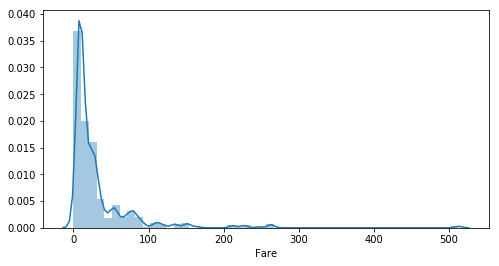

In [7]:
# 圖片大小，要先寫
plt.figure(figsize=(8,4))
# 顯示train中，Fare與目標值的散佈圖
sns.distplot(t006['Fare'][:train_cnt])
plt.show()

In [8]:
# 把t006拿來做MME
t006_MME = MME.fit_transform(t006)
# 把t006_MME在train的部分列出來
train_X_MME = t006_MME[:train_cnt]
# 接著有X有Y就能跑分數了
cross_val_score(LR, train_X_MME, train_Y, cv=5).mean()

0.7016289882888318

# 作業1 
* 試著在鐵達尼的票價 (Fare) 欄位中使用對數去偏 (log1p) , 結果是否更好?

在Python中，要新增一個【拿舊欄位運算的新欄位】並不簡單。  
因為Python很常拿新的取代掉舊的，這會導致舊的如果要再拿來作其他用途，會找不到舊的可以用。  
目前學下來大概有兩個方法：  

1. 先隨便複製一個欄位出來，當作新欄位即將要使用的位置，然後將做出來的新欄位取代掉複製的欄位。  
2. 直接複製data，例如本日的作法，以df_fixed = copy.deepcopy(df)  

但我不解的是，不能直接寫成 df_fixed = df 就好嗎？ 就像我寫的t006_2 = t006一樣  
經過測試，發現不行！我以為t006_2是複製一張表出來，結果根本不是！只是幫這張表另外設定一個名稱而已！  
所以不管後面對t006_2做了什麼，都會影響到t006本人。  

而這邊也不適合用方法1.，因為整個迴歸是拿整份欄位下去跑，如果現在新增一個欄位，假設是Fare_2，  
那Fare_2和原本的Fare一起跑，就會有線性重合的問題，所以方法2才是正解，既保留原表的Fare，又能複製一張表以新的Fare製作。  

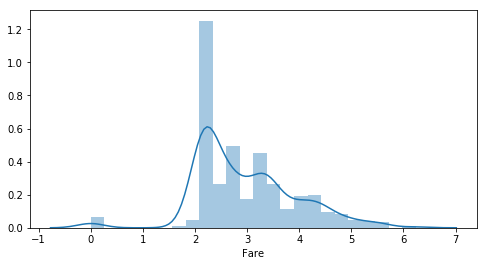

In [9]:
# 使用方法2複製一張表出來
t006_2 = copy.deepcopy(t006)
# 將 Fare 取 log1p 後，塞回原本的 Fare 欄位中
t006_2['Fare'] = np.log1p(t006_2['Fare'])
# 圖片大小，要先寫
plt.figure(figsize=(8,4))
# 顯示train中，被log1p後的Fare與目標值的散佈圖
sns.distplot(t006_2['Fare'][:train_cnt])
plt.show()


In [10]:
# 把t006拿來做MME
t006_2_MME = MME.fit_transform(t006_2)
# 把t006_MME在train的部分列出來
train_X_2_MME = t006_2_MME[:train_cnt]
# 接著有X有Y就能跑分數了
cross_val_score(LR, train_X_2_MME, train_Y, cv=5).mean()

0.7106367963253961

# 作業2
* 最後的 boxcox 區塊直接執行會造成錯誤, 起因為輸入值有負值, 請問如何修正後可以使用 boxcox? (Hint : 試圖修正資料)

In [11]:
# 使用方法2複製一張表出來
t006_3 = copy.deepcopy(t006)
# 由於接著要取boxcox，但boxcox必須>0才能執行，看一下最小值有沒有>0
t006_3['Fare'].min()

0.0

所以必須先讓最小值要>0  
教材中是直接【+1】，但這實在不是一個很好的範例，因為【+1】這件事情很容易發生在其他語法內，  
例如前些日子提到的range(i)，就必須【+1】，也只能【+1】。  
但現在不是，目的既然只是要讓這個欄位>0，那+0.0000000001也可以吧？  
寫成【+1】，很容易讓人【誤解以為只能寫成+1】，這種教材並不好。  
況且，萬一現在大部分數值是介於0~1之間，+1豈不是造成了莫名大的影響嗎？

In [12]:
# 修正方式 : 加入下面這一行, 使最小值大於 0。將全部的數值都加一個數值。
t006_3['Fare'] = t006_3['Fare'] + 0.000000000000000000001
# 可以取boxcox了，取完後，直接塞回原本Fare這個欄位內(Python真的很容易取代掉舊欄位)
t006_3['Fare'] = stats.boxcox(t006_3['Fare'])[0]
t006_3['Fare'] .head()

0    2.422712
1    6.685533
2    2.555341
3    6.022924
4    2.578899
Name: Fare, dtype: float64

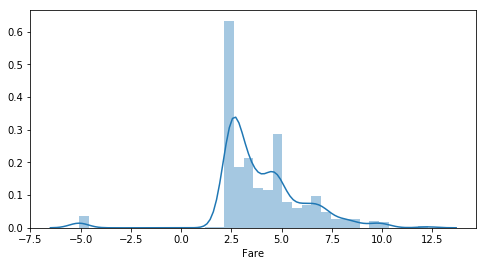

In [13]:
# 圖片大小，要先寫
plt.figure(figsize=(8,4))
# 顯示train中，被boxcox後的Fare與目標值的散佈圖
sns.distplot(t006_3['Fare'][:train_cnt])
plt.show()

In [14]:
# 把t006拿來做MME
t006_3_MME = MME.fit_transform(t006_3)
# 把t006_MME在train的部分列出來
train_X_3_MME = t006_3_MME[:train_cnt]
# 接著有X有Y就能跑分數了
cross_val_score(LR, train_X_3_MME, train_Y, cv=5).mean()

0.7128777811941116

## ------------分隔線------------

In [15]:
# 使用方法2複製一張表出來
t006_4 = copy.deepcopy(t006)
# 由於接著要取boxcox，但boxcox必須>0才能執行，看一下最小值有沒有>0
t006_4['Fare'].min()

0.0

In [16]:
# 修正方式 : 加入下面這一行, 使最小值大於 0。只對0做修正。
t006_4.loc[t006_4['Fare'] == 0,'Fare'] = 0.001
# 可以取boxcox了，取完後，直接塞回原本Fare這個欄位內(Python真的很容易取代掉舊欄位)
t006_4['Fare'] = stats.boxcox(t006_4['Fare'])[0]
t006_4['Fare'] .head()

0    2.409228
1    6.600239
2    2.540443
3    5.951934
4    2.563742
Name: Fare, dtype: float64

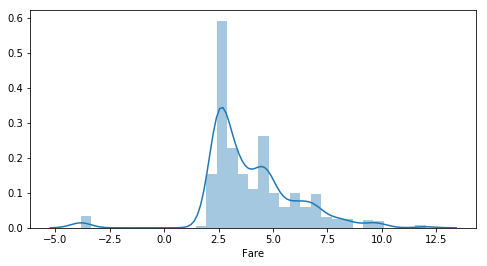

In [17]:
# 圖片大小，要先寫
plt.figure(figsize=(8,4))
# 顯示train中，被boxcox後的Fare與目標值的散佈圖
sns.distplot(t006_4['Fare'][:train_cnt])
plt.show()

In [18]:
# 把t006拿來做MME
t006_4_MME = MME.fit_transform(t006_4)
# 把t006_MME在train的部分列出來
train_X_4_MME = t006_4_MME[:train_cnt]
# 接著有X有Y就能跑分數了
cross_val_score(LR, train_X_4_MME, train_Y, cv=5).mean()

0.7128777811941116

In [ ]:
### Day21教材方向和目標
1. 今天主要看PDF的觀念

### Day21忽略部分
1. boxcox的細節

### Day21其他補充
關於新增欄位、複製資料的概念很重要，原因原理也很重要。 